# Project 1: Image Feature Extraction and Matching

This is Project 1 for [UW CSE P576 Computer Vision](https://courses.cs.washington.edu/courses/csep576/18sp). 

**Getting Started:** To get started, **[download the source files here (Projects 1 and 2)](https://courses.cs.washington.edu/courses/csep576/18sp/projects/project12/project12.zip "Project 1 and 2 Source Files")**. To run the project locally you will need IPython/Jupyter installed, e.g., see instructions at http://jupyter.org/install.html. Launch Jupyter and open `Project1.ipynb`. Alternatively, you can import the standalone version of the notebook into [Colaboratory](https://colab.research.google.com "Colab") and run it without installing anything. Use File->Upload Notebook in Colab and open the notebook in `standalone/Project1s.ipynb`.

**This project:** In this project you will build an image feature matcher, starting with simple convolution operations and working through interest point detection and descriptor extraction. Once you have a basic feature matcher working, try out some improvements and document your results. If you’re not already familiar with python/numpy, it is recommended to do an introduction such as: http://cs231n.github.io/python-numpy-tutorial. 

**What to turn in:** Turn in a pdf or static html copy of your completed ipynb notebook as well as the source .ipynb and any source .py files that you modified. Clearly describe any enhancements or experiments you tried in your ipynb notebook.

In [110]:
# Experiments with scipy.max filter

import numpy as np
import scipy.ndimage.filters as filters

# print('Arr = ')
arr = np.array([
    [9,1,9],
    [4,5,6],
    [7,8,8],
    [5,6,2]
]
)

# print('3D Arr = ')
arr2 = arr[:,:,np.newaxis]
# print(arr2.shape, arr2)
footprint = np.expand_dims(np.ones((3,3)), axis=2)
print('Mask Shape = {}'.format(footprint.shape))

# Get Local Maximum values
mx = filters.maximum_filter(input=arr2,footprint=footprint)
print('Local Max = ')
print(np.squeeze(mx))

threshold = 8
H,W,_ = np.where((arr2 == mx) & (mx >= threshold))


rc = np.array([H,W])

num_col = rc.shape[1]
print(num_col)

W


Mask Shape = (3, 3, 1)
Local Max = 
[[9 9 9]
 [9 9 9]
 [8 8 8]
 [8 8 8]]
4


array([0, 2, 1, 2])

In [111]:
img_size = 8
num_dims = 64
img = np.arange(64).reshape((img_size, img_size))
print(img)
patch_size = 3
patch_size_div2 = int(patch_size/2)
row, col  = 2, 3
print(img[row, col])

H,W = img.shape
row_start = 0 if row-patch_size_div2 < 0 else row-patch_size_div2
row_end = H if row+patch_size_div2+1 > H else row+patch_size_div2+1
col_start = 0 if col-patch_size_div2 < 0 else col-patch_size_div2
col_end = W if col+patch_size_div2+1 > W else col+patch_size_div2+1
patch = img[row_start:row_end, col_start:col_end ]
print(patch)
sample_spacing=1
patch = np.ndarray.flatten(patch)
patch = patch[::sample_spacing]
patch_size = int(np.sqrt(patch.shape))
patch = patch[:patch_size**2]
patch

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]
19
[[10 11 12]
 [18 19 20]
 [26 27 28]]


array([10, 11, 12, 18, 19, 20, 26, 27, 28])

In [112]:
import numpy as np
import os.path
from time import time
import types
import matplotlib.pyplot as plt

import im_util
import interest_point

%matplotlib inline
# edit this line to change the figure size
plt.rcParams['figure.figsize'] = (16.0, 10.0)
# force auto-reload of import modules before running code 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Convolution and Image Filtering [25%]

Start by writing code to perform convolution in 1D. Open `im_util.py` and edit the function `convolve_1d`. You should use only basic numpy array operations and loops. Don't worry about efficiency for now. You should see small errors compared to the reference numpy version.

Note that convolution and correlation are the same under a simple manipulation of the kernel (what is it?). For what kernels are convolution and correlation results identical?

In [113]:
import im_util
"""
Test of convolve_1d
"""
print('[ Test convolve_1d ]')
x = (np.random.rand(20)>0.8).astype(np.float32)
k = np.array([1,3,1])
y1 = im_util.convolve_1d(x, k)
y2 = np.convolve(x, k, 'same')
y3 = np.correlate(x, k, 'same')
print(' convolve error = ', np.sum((y1-y2)**2))
print(' correlate error = ', np.sum((y1-y3)**2))

[ Test convolve_1d ]
 convolve error =  0.0
 correlate error =  0.0


We will now convolve a 2D image with a 1D kernel. Before you begin, get some image data by running `get_data.sh` in the `data` directory. Then complete the function `convolve_rows` in `im_util.py` by convolving every row of the image by the kernel. Run the code below and check that the image output is sensible.

In [114]:
# Uncomment this, if running for the first time
#! /bin/sh data/get_data.sh && mv test/ data/test/ && rm -f test/

[ Test convolve_image ]
 convolve_rows
(758, 568, 3)
(11,)
  8.53 secs
 scipy convolve
  0.05 secs
 convolve_image error = 4.09691406655e-07


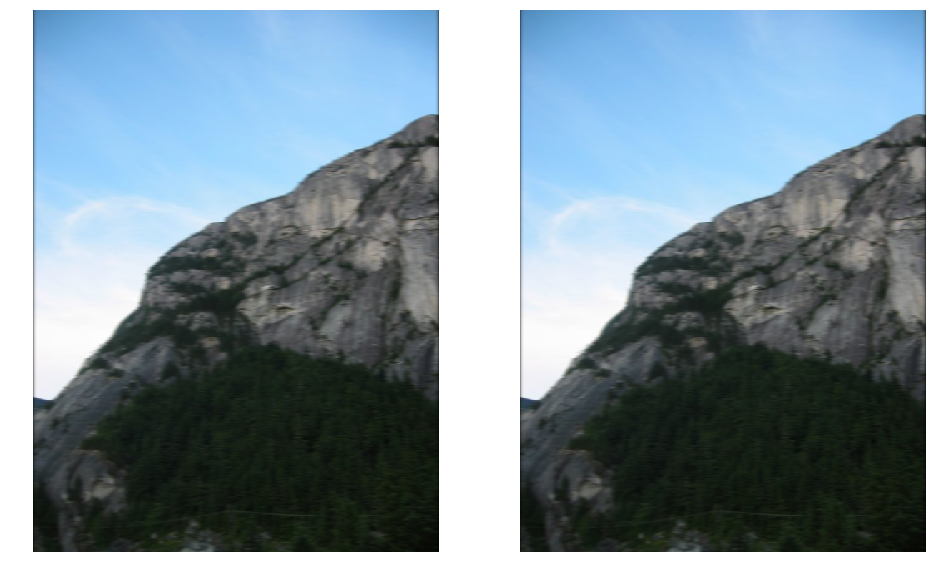

In [115]:
"""
Test of convolve_image
"""
image_filename='data/test/100-0038_img.jpg'

print('[ Test convolve_image ]')
im = im_util.image_open(image_filename)
k = np.array([1,2,3,4,5,6,5,4,3,2,1])
print(' convolve_rows')
t0=time()
im1 = im_util.convolve_rows(im, k)
t1=time()
print(' % .2f secs' % (t1-t0))
print(' scipy convolve')
t0=time()
im2 = im_util.convolve(im, np.expand_dims(k,0))
t1=time()
print(' % .2f secs' % (t1-t0))
print(' convolve_image error =', np.sum((im1-im2)**2))

# optionally plot images for debugging
im1_norm=im_util.normalise_01(im1)
im2_norm=im_util.normalise_01(im2)
ax1,ax2=im_util.plot_two_images(im1_norm, im2_norm)          

You will probably find that the scipy convolve runs much faster than your version. To speed things up you can use this version (`im_util.convolve`) for all subsequent experiments. Note that this performs a general 2D convolution with a 2D kernel as input. 

Now write code to perform Gaussian blurring. First implement the function `gauss_kernel` to compute a 1D Gaussian kernel. Then complete `convolve_gaussian` to perform a separable convolution with this kernel.

[ Test convolve_gaussian ]
8
 gauss kernel = 
[[ 0.01349774  0.02156933  0.0323794   0.04566227  0.06049268  0.07528436
   0.08801633  0.09666703  0.09973557  0.09666703  0.08801633  0.07528436
   0.06049268  0.04566227  0.0323794   0.02156933  0.01349774]]
8
  0.31 secs


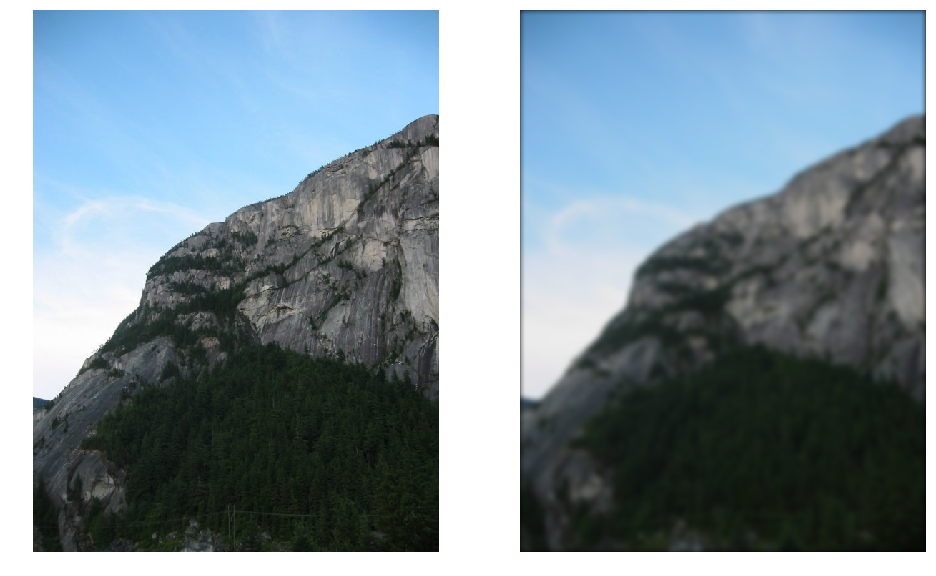

In [116]:
"""
Gaussian blurring test
"""
print('[ Test convolve_gaussian ]')

sigma=4.0
k=im_util.gauss_kernel(sigma)
print(' gauss kernel = ')
print(k)

t0=time()
im1 = im_util.convolve_gaussian(im, sigma)
t1=time()
print(' % .2f secs' % (t1-t0))

ax1,ax2=im_util.plot_two_images(im, im1)

Now write code to compute horizontal and vertical gradients in the function `compute_gradients`. Use an explicit kernel that is convolved in each direction (i.e., do not use a built-in function such as `numpy.gradient`). Run the code below and check that the outputs look sensible.

[ Test gradient computation ]
(758, 568, 1)


(<matplotlib.axes._subplots.AxesSubplot at 0x113811a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11edbeb38>)

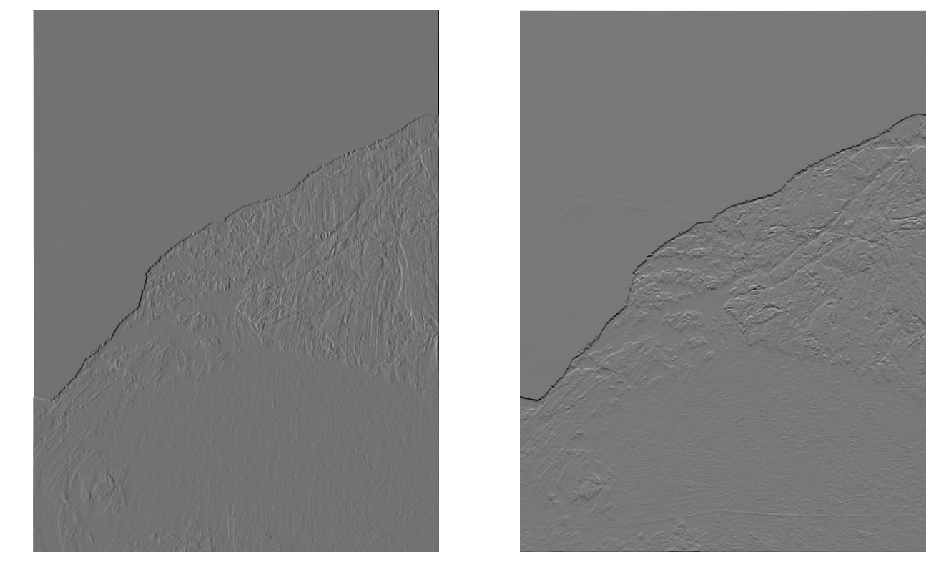

In [117]:
"""
Gradient computation test
"""
print('[ Test gradient computation ]')
img = np.mean(im,2,keepdims=True)
print(img.shape)
Ix,Iy = im_util.compute_gradients(img)

# copy greyvalue to RGB channels
Ix_out = im_util.grey_to_rgb(im_util.normalise_01(Ix))
Iy_out = im_util.grey_to_rgb(im_util.normalise_01(Iy))

im_util.plot_two_images(Ix_out, Iy_out)

### Interest Point Extractor [25%]

Now you will use these convolution functions to implement a corner or interest point detector. Choose a well known detector, such as Harris or DoG, and implement the interest point strength function in `corner_function` of `interest_point.py`. Run the code below to visualise your corner function output. Next detect corners as local maxima of this function by filling in `find_local_maxima` in the same file.

[ Compute corner strength ]
Using DoG
13
8
p5, p95
-0.0361737190247
0.0152756272452
[ Find local maxima ]
Footprint: (15, 15, 1)
Threshold: 0.015275627245164196
Num interest points: 200 Min/Max Row 151 736Min/Max Col 0 567
Num interest points after border_pixels: 188 188
CPU times: user 727 ms, sys: 25.4 ms, total: 753 ms
Wall time: 760 ms


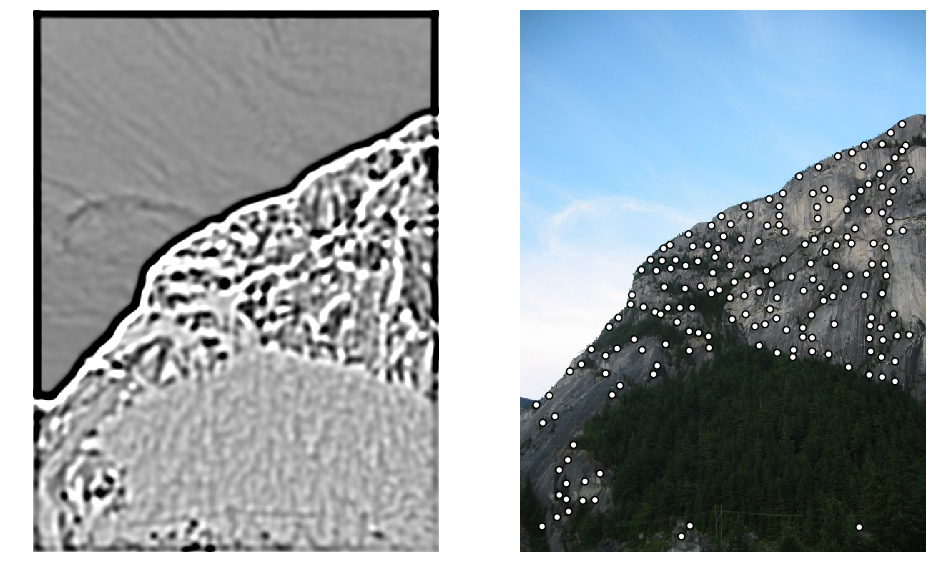

In [118]:
%%time
"""
Compute corner strength function
"""
print('[ Compute corner strength ]')
ip_ex = interest_point.InterestPointExtractor()
ip_fun = ip_ex.corner_function(img)

# normalise for display
[mn,mx]=np.percentile(ip_fun,[5,95])
print('p5, p95')
print(mn)
print(mx)
small_val=1e-9
ip_fun_norm=(ip_fun-mn)/(mx-mn+small_val)
ip_fun_norm=np.maximum(np.minimum(ip_fun_norm,1.0),0.0)

"""
Find local maxima of corner strength
"""
print('[ Find local maxima ]')
row, col = ip_ex.find_local_maxima(ip_fun)
ip = np.stack((row,col))

ax1,ax2=im_util.plot_two_images(im_util.grey_to_rgb(ip_fun_norm),im)
interest_point.draw_interest_points_ax(ip, ax2)

### Descriptors and Matching [25%]

Now let's match our interest points. Start by extracting a very simple descriptor that is simply a patch of pixels around the interest point. To do this, fill in the function `get_descriptors` in `interest_point.py`. The following code outputs a random sample of normalised descriptor patches. Check that the output looks sensible. Once you have this working, try varying the sample spacing in your descriptor patch. What problem exists with sample spacings > 1 pixel? How can this be fixed?

#### What problems exist with sample spacing > 1 pixel
As we increase the sample size, it may skip pixels that are representative to the descriptor and we will sample less pixels around the interest point and it may lead to false positives or false negatives if the important pixels don't get sampled. We also have to keep increasing the overall patch size as we increase the sample size so that we get a good number of pixels in the sample.

To a lesser extent, I think there is also a small performance overhead(at-least in-memory, if not storage cost) because we have to  extract a large patch first and  *then* sample it, i.e., we are doing work on more pixels than we end up using.

#### How can this be fixed? 
Sampling is OK and is used in various types of descriptors. Rather than doing just a a sampling by fixed spacing, we could do a weighted sampling by using a gaussian distribution so that more points get sampled around the interest point.

A weighted sampling may also be employed which assigns more weight to pixels nearer to the interest point OR the sample space is smaller closer to the interest point and gets higher as we move away from it

[ Extract descriptors ]
Patch size: 21 Num_dims: 441 , ip (2, 188), img (758, 568, 1)


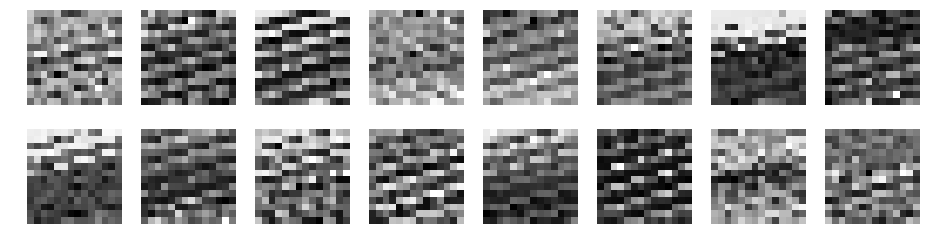

In [141]:
"""
Extract descriptors
"""
print('[ Extract descriptors ]')
desc_ex=interest_point.DescriptorExtractor()
descriptors=desc_ex.get_descriptors(img, ip)
interest_point.plot_descriptors(descriptors,plt)

We will now match descriptors between a pair of images. Run the following two code blocks to extract your interest points and extract and match descriptors. The second code block calls a function to perform nearest-neighbour matching of descriptors and filtering using a ratio test. Take a look at the code and check you understand how it works.

[ find interest points ]
Using DoG
13
8
Footprint: (15, 15, 1)
Threshold: 0.015275627245164196
Num interest points: 200 Min/Max Row 151 736Min/Max Col 0 567
Num interest points after border_pixels: 183 183
 found 183 in image 1
Using DoG
13
8
Footprint: (15, 15, 1)
Threshold: 0.0213733354908215
Num interest points: 247 Min/Max Row 181 695Min/Max Col 0 554
Num interest points after border_pixels: 230 230
 found 230 in image 2
  0.70 secs 
[ drawing interest points ]
  0.83 secs 


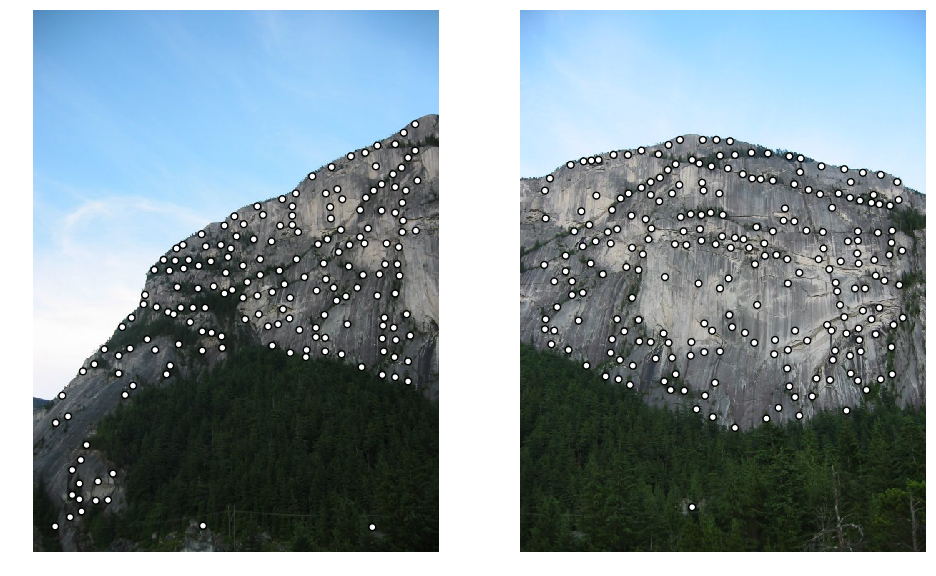

In [142]:
"""
Read a pair of input images and extract interest points
"""
image_dir='data/test'
#im_filename1=image_dir+'/100-0023_img.jpg'
#im_filename2=image_dir+'/100-0024_img.jpg'
im_filename1=image_dir+'/100-0038_img.jpg'
im_filename2=image_dir+'/100-0039_img.jpg'

im1 = im_util.image_open(im_filename1)
im2 = im_util.image_open(im_filename2)

img1 = np.mean(im1, 2, keepdims=True)
img2 = np.mean(im2, 2, keepdims=True)

print('[ find interest points ]')
t0=time()
ip_ex = interest_point.InterestPointExtractor()
ip1 = ip_ex.find_interest_points(img1)
print(' found '+str(ip1.shape[1])+' in image 1')
ip2 = ip_ex.find_interest_points(img2)
print(' found '+str(ip2.shape[1])+' in image 2')
t1=time()
print(' % .2f secs ' % (t1-t0))

print('[ drawing interest points ]')
ax1,ax2=im_util.plot_two_images(im1,im2)
t0=time()
interest_point.draw_interest_points_ax(ip1, ax1)
interest_point.draw_interest_points_ax(ip2, ax2)
t1=time()
print(' % .2f secs ' % (t1-t0))

[ extract descriptors ]
Patch size: 21 Num_dims: 441 , ip (2, 183), img (758, 568, 1)
Patch size: 21 Num_dims: 441 , ip (2, 230), img (758, 568, 1)
  0.01 secs
[ match descriptors ]
 Number of interest points = 183
 Number of matches passing ratio test = 77


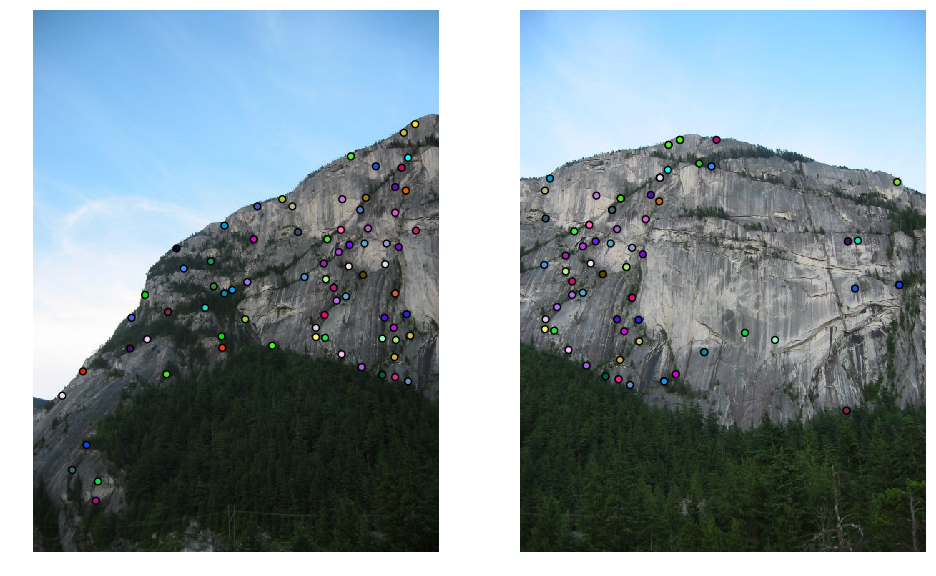

In [143]:
"""
Extract and match descriptors
"""
print('[ extract descriptors ]')
t0=time()
desc_ex = interest_point.DescriptorExtractor()
desc1 = desc_ex.get_descriptors(img1, ip1)
desc2 = desc_ex.get_descriptors(img2, ip2)
t1=time()
print(' % .2f secs' % (t1-t0))

print('[ match descriptors ]')
match_idx,ratio_pass=desc_ex.match_ratio_test(desc1, desc2)
num_ratio_pass=np.sum(ratio_pass)

ipm=ip2[:,match_idx]

ip1r=ip1[:,ratio_pass]
ip2r=ipm[:,ratio_pass]

N1,num_dims=desc1.shape
print(' Number of interest points = '+str(N1))
print(' Number of matches passing ratio test = '+str(num_ratio_pass))

ax1,ax2=im_util.plot_two_images(im1,im2)
interest_point.draw_matches_ax(ip1r, ip2r, ax1, ax2)


The following code visualises matched descriptor patches. Can you distinguish the correct and incorrect matches? (reload to get another random sample).

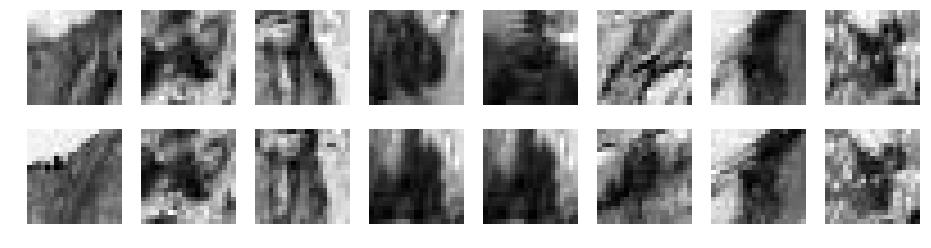

In [140]:
"""
Plot descriptors for matched points
"""
interest_point.plot_matching_descriptors(desc1,desc2,np.arange(0,ip1.shape[1]),match_idx,plt)

### RESULTS

| Border Pixels | Patch Size    | Ratio_Threshold  | Points Matched  |
| ------------- |---------------| -----------------| -----------------|
| 20            | 17            | .75              | 43              |
| 30            | 21            | .75              | 45              |
| 30            | 23            | .75              | 44              |
| 30            | 23            | .85              | 71              |
| 30            | 21            | .85              | 79              |
| 30            | 21            | .75              | 61              |

### Testing and Improving Feature Matching [25%]

Try varying the `ratio_threshold` parameter in the descriptor matcher (`DescriptorExtractor` class params). What are good settings for this parameter? If everything is working, you should see a good set of correctly matched points (aim for about 100 or more). Experiment with your interest point and descriptor implementations to find which parameters are important and try to get a good set of matches. Try out a new idea of your own to improve interest points or descriptors, and record your findings in the notebook below.


#### Experimentain with Interest Point

I implemented Harris Corners for detection too. (See commented out code in interest_point.py). Eventually I went with DoG. I think DoG is simpler and easier to implement bug-free. It also appears to be computationally less expensive since we're doing multiple convolutiions in Harris Corners vs just the two in DoG. Simpler is better! It's easier to test;

#### Experimenting with Descriptors

First attempt was at a simple descriptor which extracts a patch. The parameter here was the radius of the patch. I went with mostly odd sized patches so the interest point is at the center. Important thing here is to vary border_pixels along with patch_size. If patch size is much larger than border_pixels , then some descriptors will be incomplete as they'll overeach the image. 


